# Recommender Systems 2021/2022

## Practice - Hybrid Recommenders

### There are several strategies you can adopt to create hybrid models
* Stacking URM, ICM, UCM
* Combine already available models all with the same model structure
* Combine already available models with different model structure
* Combine already available models with rating prediction vs ranking loss functions
* User-wise discrimination

## Some basic information about hybrid models

### The way to go to achieve the best recommendation quality
In order to create an effective hybrid model you need a few things:
* Reasonably well performing models
* Models must look at the task in (at least slightly) different ways
* It must be possible to combine the two

There are many different types of hybrids, we will be covering only some of them.


### In Movielens10M we have the usual URM, but also several ICMs

In [1]:
import scipy.sparse as sps

from Data_manager.split_functions.split_train_validation_random_holdout import \
    split_train_in_two_percentage_global_sample
from Evaluation.Evaluator import EvaluatorHoldout
from Recommenders.KNN import ItemKNNCustomSimilarityRecommender
from challenge.utils.functions import read_data, generate_submission_csv

data_file_path = '../challenge/input_files/data_train.csv'
users_file_path = '../challenge/input_files/data_target_users_test.csv'
URM_all_dataframe, users_list = read_data(data_file_path, users_file_path)

URM_all = sps.coo_matrix(
    (URM_all_dataframe['Data'].values, (URM_all_dataframe['UserID'].values, URM_all_dataframe['ItemID'].values)))
URM_all = URM_all.tocsr()

URM_train_validation, URM_test = split_train_in_two_percentage_global_sample(URM_all, train_percentage=0.80)
URM_train, URM_validation = split_train_in_two_percentage_global_sample(URM_train_validation, train_percentage=0.85)

In [2]:
from Evaluation.Evaluator import EvaluatorHoldout

cutoff_list=[5, 10, 15]

evaluator_validation = EvaluatorHoldout(URM_validation, cutoff_list=cutoff_list)
evaluator_test = EvaluatorHoldout(URM_test, cutoff_list=cutoff_list)

EvaluatorHoldout: Ignoring 3650 (28.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 2541 (19.5%) Users that have less than 1 test interactions


# Stacking

A simple idea is to look at both iteractions and features as a similar type of information. Given an item, you can see the users that interacted with it as *features* of that item, in the same way as its genre.

To do so, you can concatenate URM and ICM in a single data structure of shape |n_users + n_features|x|n_items|

WARNING: You are creating a new matrix that can be used as URM or ICM interchangeably and plugged into any model you already have. This gives you flexibility but requires caution, for example, what happens if you use that stacked URM in a UserBasedKNN vs in an ItemBasedKNN? (hint: only in one it makes sense)

import scipy.sparse as sps

ICM_genres = data_loaded.get_loaded_ICM_dict()["ICM_genres"]

stacked_URM = sps.vstack([URM_train, ICM_genres.T])
stacked_URM = sps.csr_matrix(stacked_URM)

stacked_ICM = sps.csr_matrix(stacked_URM.T)

stacked_URM, stacked_ICM

At this point you can use it to train any model you have. Suggestions:
* If one of the two is much larger than the other (like in this case, 60k users vs 20 features) the smaller will be overwhelmed numerically. Add a weight to the smaller one to increase its importance (will only work for models that allow explicit interactions, will not work with models that use implicit ones)
* If the ICM has a bad recommendation quality, maybe stacking will not help
* When computing a item-based similarity, you can also use only *some* of the features or users. This is called feature selection and is a wide area of research.

from Recommenders.KNN.ItemKNNCFRecommender import ItemKNNCFRecommender
from Recommenders.KNN.ItemKNNCBFRecommender import ItemKNNCBFRecommender

recommender_ItemKNNCF = ItemKNNCFRecommender(stacked_URM)
recommender_ItemKNNCF.fit()

result_df, _ = evaluator_validation.evaluateRecommender(recommender_ItemKNNCF)
result_df

recommender_ItemKNNCBF = ItemKNNCBFRecommender(URM_train, stacked_ICM)
recommender_ItemKNNCBF.fit()

result_df, _ = evaluator_validation.evaluateRecommender(recommender_ItemKNNCBF)
result_df

The framework already includes a model that does stacking, but only applied to the KNNs

from Recommenders.KNN.ItemKNN_CFCBF_Hybrid_Recommender import ItemKNN_CFCBF_Hybrid_Recommender

recommender_ItemKNNCFCBF = ItemKNN_CFCBF_Hybrid_Recommender(URM_train, ICM_genres)
recommender_ItemKNNCFCBF.fit(ICM_weight = 10.0)

result_df, _ = evaluator_validation.evaluateRecommender(recommender_ItemKNNCFCBF)
result_df

# Hybrid of models with the same structure

The underlying idea is that if you have some models with the same underlying structure, you can merge them in a single one. The result is to define a function that give the various model's parameters creates a new model with its own parameters.
In this example we will see how to combine different item-item similarity models in a new one.

In particular: `ItemKNNCFRecommender` and `P3AlphaRecommender`. Both use and learn a similarity matrix to provide recommendations. Notice that here we are merging a KNN-based with a Graph-based model.


In [3]:
from Recommenders.KNN.ItemKNNCFRecommender import ItemKNNCFRecommender

itemKNNCF = ItemKNNCFRecommender(URM_train)
itemKNNCF.fit(topK=10, shrink=19, similarity='jaccard', normalize=False, feature_weighting="TF-IDF")

ItemKNNCFRecommender: URM Detected 802 ( 6.2%) users with no interactions.
ItemKNNCFRecommender: URM Detected 408 ( 1.8%) items with no interactions.
Unable to load Cython Compute_Similarity, reverting to Python
Similarity column 22348 (100.0%), 1289.48 column/sec. Elapsed time 17.33 sec


<22348x22348 sparse matrix of type '<class 'numpy.float32'>'
	with 219016 stored elements in Compressed Sparse Row format>

In [4]:
from Recommenders.GraphBased.P3alphaRecommender import P3alphaRecommender

P3alpha = P3alphaRecommender(URM_train)
P3alpha.fit(topK=64, alpha=0.35496275558011753, min_rating=0.1, implicit=True, normalize_similarity=True)

P3alphaRecommender: URM Detected 802 ( 6.2%) users with no interactions.
P3alphaRecommender: URM Detected 408 ( 1.8%) items with no interactions.
P3alphaRecommender: Similarity column 22348 (100.0%), 4576.90 column/sec. Elapsed time 4.88 sec


<22348x22348 sparse matrix of type '<class 'numpy.float32'>'
	with 590744 stored elements in Compressed Sparse Row format>

Now that we have both models fit with `URM_train` how can we merge them?


Well, we could take the advantage that they have the same underlying structure, i.e. a similarity matrix

In [5]:
itemKNNCF.W_sparse

<22348x22348 sparse matrix of type '<class 'numpy.float32'>'
	with 219016 stored elements in Compressed Sparse Row format>

In [6]:
P3alpha.W_sparse

<22348x22348 sparse matrix of type '<class 'numpy.float32'>'
	with 590744 stored elements in Compressed Sparse Row format>

When we create hybrids we always have to account for:
* A weight, which is a hyperparameter to tune. 
* What is the range and distribution of the values we are merging

Imagine that the values of one similarity are orders of magnitude higher than the other, then the smaller values would get absorbed by the bigger ones. 

In [7]:
alpha = 0.7
new_similarity = (1 - alpha) * itemKNNCF.W_sparse + alpha * P3alpha.W_sparse
new_similarity

<22348x22348 sparse matrix of type '<class 'numpy.float32'>'
	with 690881 stored elements in Compressed Sparse Row format>

Moreover, we can apply the same optimizations to this similarity as we applied to the others (for example: topK neighbors)

The framework includes a recommender class which supports a custom similarity

In [8]:
from Recommenders.KNN.ItemKNNCustomSimilarityRecommender import ItemKNNCustomSimilarityRecommender

recommender_object = ItemKNNCustomSimilarityRecommender(URM_train)
recommender_object.fit(new_similarity)

result_df, _ = evaluator_validation.evaluateRecommender(recommender_object)
result_df

ItemKNNCustomSimilarityRecommender: URM Detected 802 ( 6.2%) users with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 408 ( 1.8%) items with no interactions.
EvaluatorHoldout: Processed 9375 (100.0%) in 12.37 sec. Users per second: 758


,PRECISION,PRECISION_RECALL_MIN_DEN,RECALL,MAP,MAP_MIN_DEN,MRR,NDCG,F1,HIT_RATE,ARHR_ALL_HITS,...,COVERAGE_USER,COVERAGE_USER_HIT,USERS_IN_GT,DIVERSITY_GINI,SHANNON_ENTROPY,RATIO_DIVERSITY_HERFINDAHL,RATIO_DIVERSITY_GINI,RATIO_SHANNON_ENTROPY,RATIO_AVERAGE_POPULARITY,RATIO_NOVELTY
cutoff,,,,,,,,,,,,,,,,,,,,,
5,0.068523,0.103271,0.081838,0.039095,0.058762,0.157095,0.093601,0.074591,0.28128,0.175223,...,0.71977,0.202457,0.71977,0.052172,10.026482,0.997533,0.152385,0.77305,1.654,0.177276
10,0.055659,0.131554,0.12355,0.024264,0.057718,0.171699,0.104173,0.076744,0.391147,0.203343,...,0.71977,0.281536,0.71977,0.077404,10.602353,0.998417,0.226085,0.81745,1.513007,0.361567
15,0.047765,0.155169,0.151489,0.017892,0.059131,0.176662,0.112937,0.07263,0.45344,0.215922,...,0.71977,0.326372,0.71977,0.096635,10.929957,0.998792,0.282256,0.842708,1.431542,0.549283


### Analysis of similarities

Now that we have seen how to build a hybrid like this, let's see how different are the different similarities matrices built by each recommender (CBF, CF, and CFCBF).

ItemKNNCFRecommender: URM Detected 802 ( 6.2%) users with no interactions.
ItemKNNCFRecommender: URM Detected 408 ( 1.8%) items with no interactions.
Unable to load Cython Compute_Similarity, reverting to Python
Similarity column 22348 (100.0%), 1542.64 column/sec. Elapsed time 14.49 sec


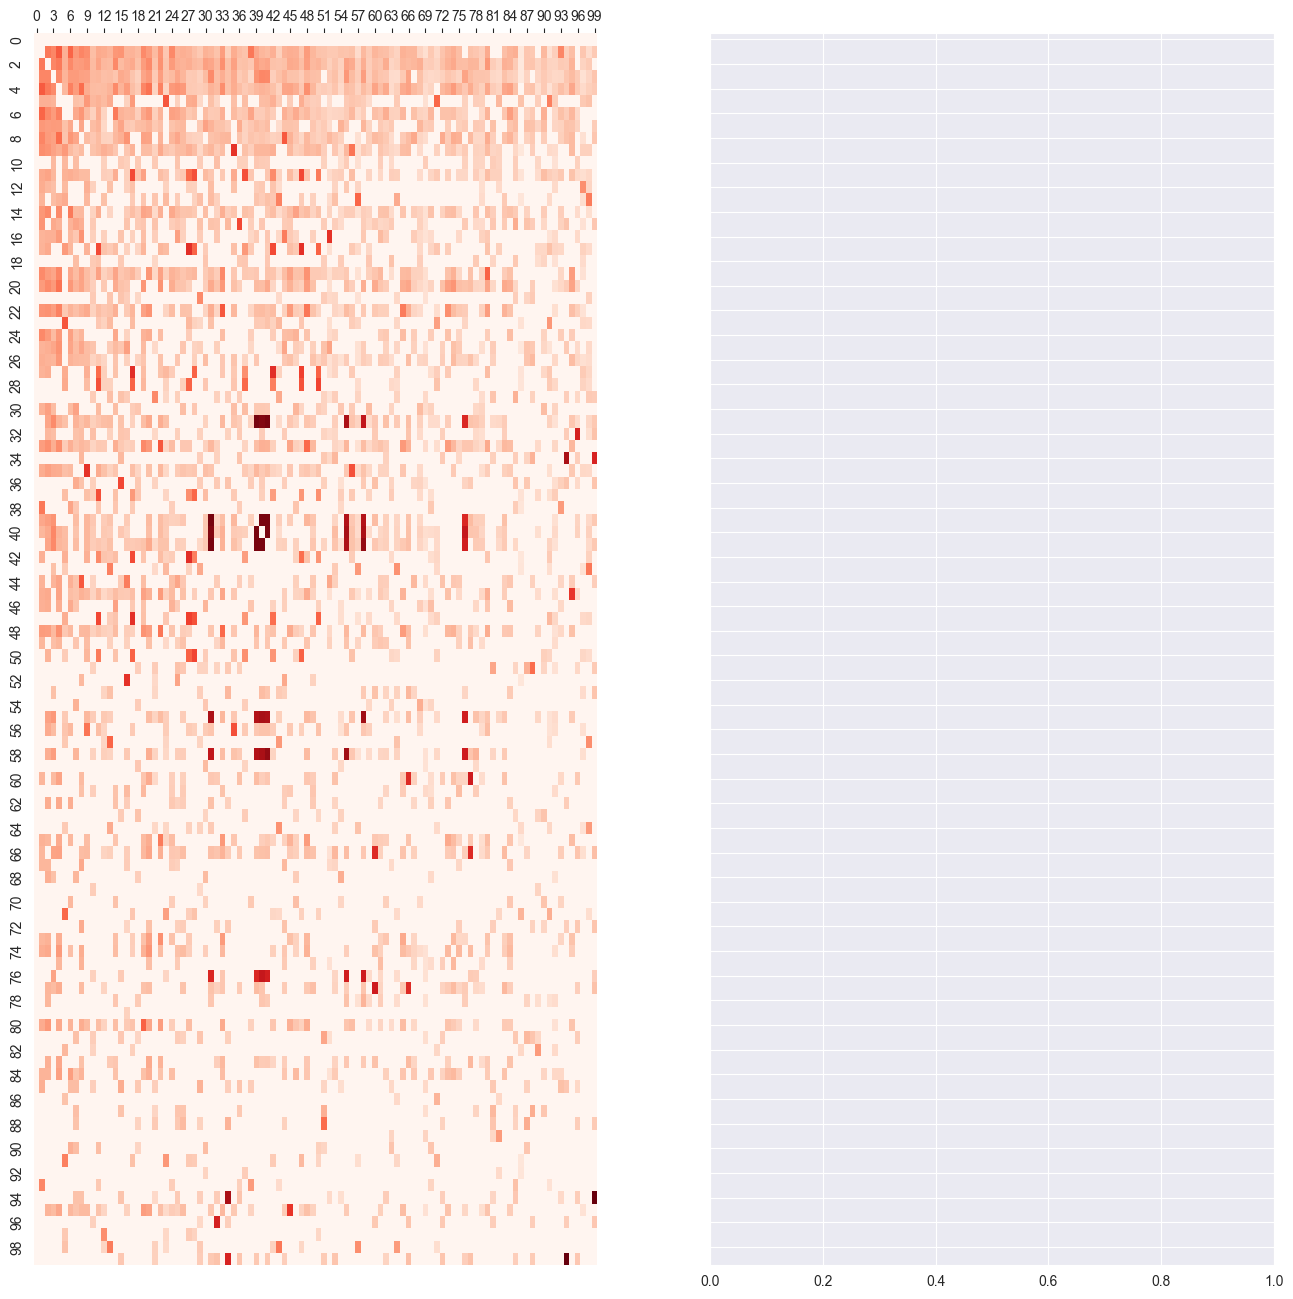

In [9]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np


recommender_ItemKNNCF = ItemKNNCFRecommender(URM_train)
recommender_ItemKNNCF.fit()

cf_sim = recommender_ItemKNNCF.W_sparse

cf_sim_max = cf_sim.max()
vmax = np.max([cf_sim_max])

f, [ax1, ax2] = plt.subplots(1, 2, figsize=(16, 16), sharey=True)
sns.heatmap(cf_sim[:100, :100].todense(), cbar=False, vmin=0, vmax=vmax, ax=ax1, cmap="Reds")
ax1.xaxis.set_ticks_position("top")

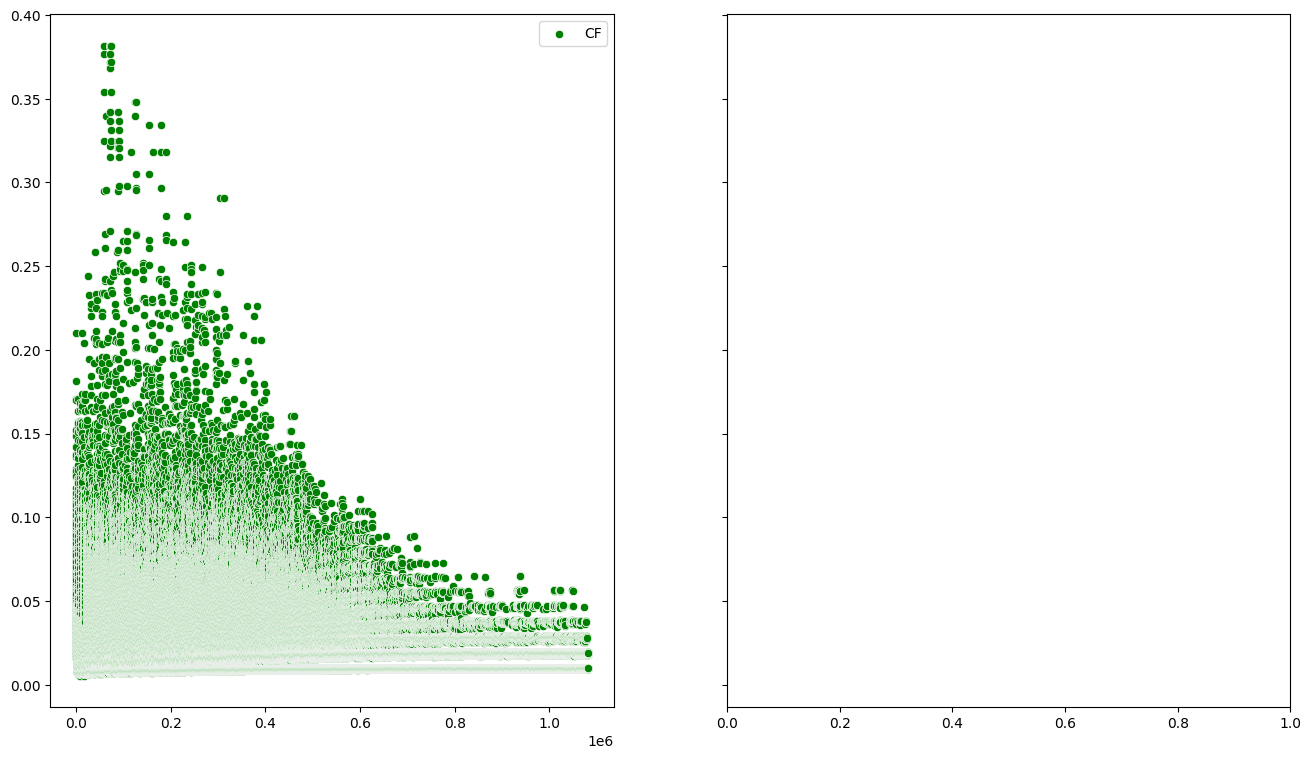

In [33]:
f, [ax1, ax2] = plt.subplots(1, 2, figsize=(16, 9), sharey=True)
sns.scatterplot(data=cf_sim.data, ax=ax1, color="green")
ax1.legend(["CF"])

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/_base.py:1606: UserWarning: Vertical orientation ignored with only `x` specified.
  warnings.warn(single_var_warning.format("Vertical", "x"))


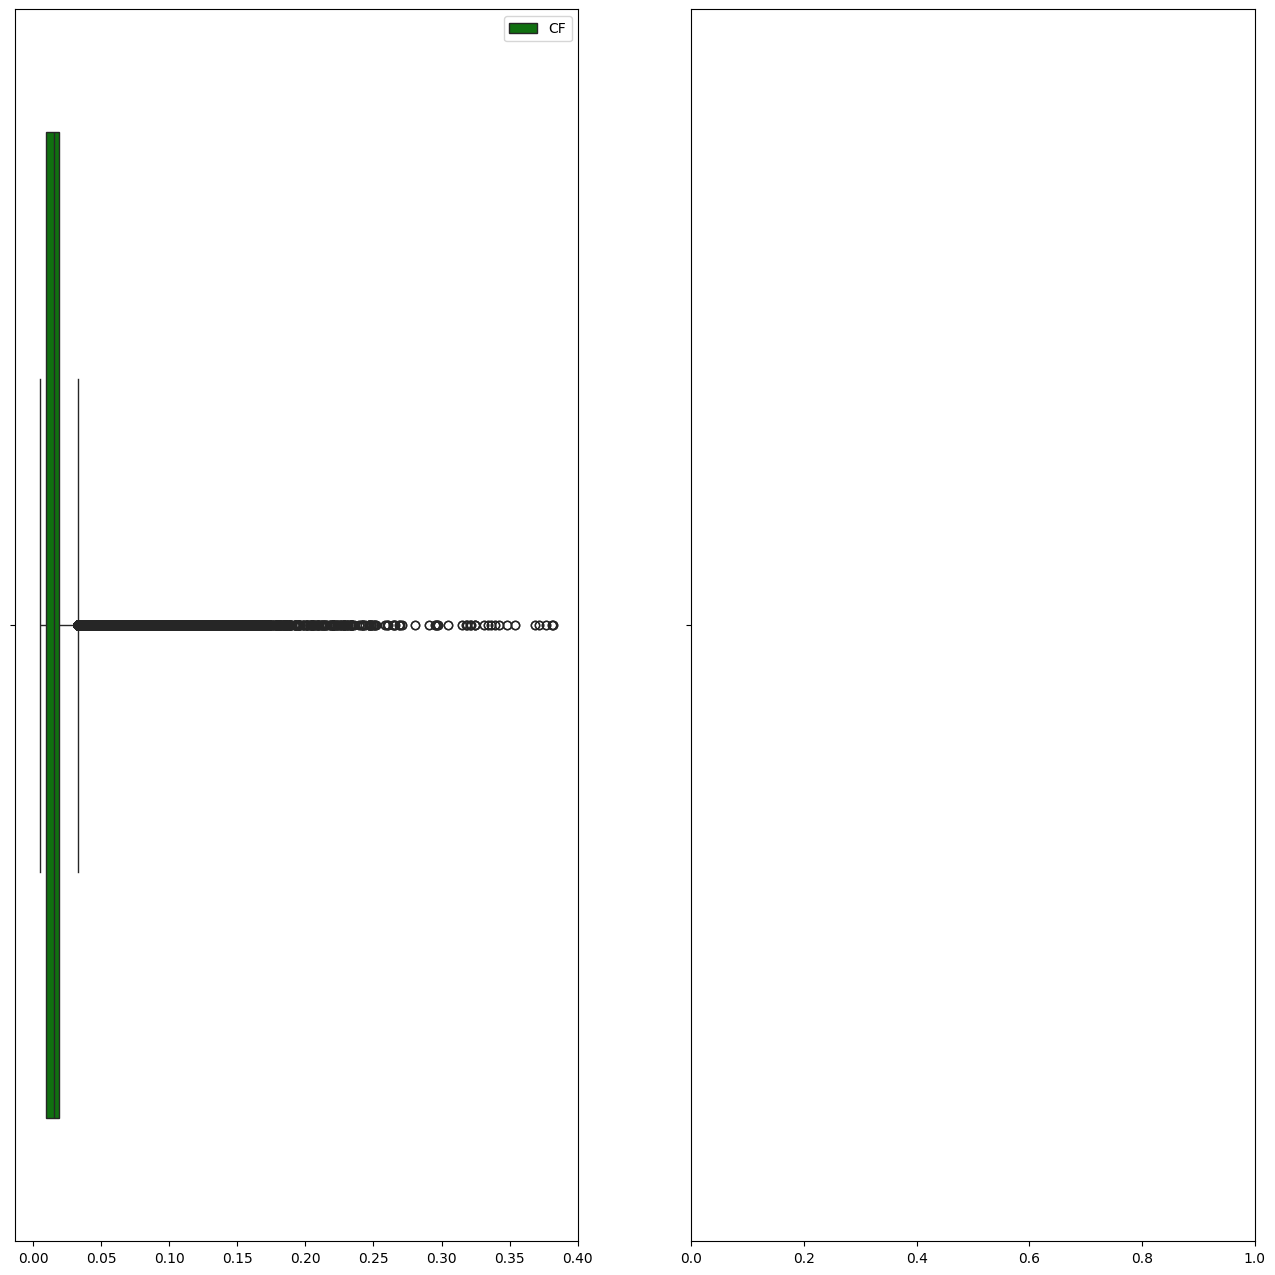

In [34]:
f, [ax1, ax2] = plt.subplots(1, 2, figsize=(16, 16), sharey=True)
sns.boxplot(x=cf_sim.data, orient="v", ax=ax1, color="green")
ax1.legend(["CF"])

# Hybrid of models with different structure

We just saw the case where models had compatible structure (ItemKNN with P3Alpha) but there are certain cases where we want to combine recommenders with different underlying structures. For instance ItemKNN and UserKNN or ItemKNN with PureSVD.

In this case we cannot combine the model parameters themselves, rather we can combine the *predictions*.

In [10]:
from Recommenders.MatrixFactorization.PureSVDRecommender import PureSVDRecommender

pureSVD = PureSVDRecommender(URM_train)
pureSVD.fit(num_factors=43)

PureSVDRecommender: URM Detected 802 ( 6.2%) users with no interactions.
PureSVDRecommender: URM Detected 408 ( 1.8%) items with no interactions.
PureSVDRecommender: Computing SVD decomposition...
PureSVDRecommender: Computing SVD decomposition... done in 0.48 sec


We can combine the predictions via a weighted average

In [11]:
user_id = 50

item_scores_itemknn = itemKNNCF._compute_item_score(user_id)

In [12]:
item_scores_puresvd = pureSVD._compute_item_score(user_id)

As you can see, we provide a score for every item in the dataset in both recommenders. 

Remember that after calculating these scores, we sort them and take the n-most relevant ones.

Again we use a weight

In [13]:
alpha = 0.7

new_item_scores = alpha * item_scores_itemknn + (1 - alpha) * item_scores_puresvd

Now we create a recommeder class. Note that again we can build a hybrid combining any number of models

In [14]:
from Recommenders.BaseRecommender import BaseRecommender

class ScoresHybridRecommender(BaseRecommender):
    """ ScoresHybridRecommender
    Hybrid of two prediction scores R = R1*alpha + R2*(1-alpha)

    """

    RECOMMENDER_NAME = "ScoresHybridRecommender"

    def __init__(self, URM_train, recommender_1, recommender_2):
        super(ScoresHybridRecommender, self).__init__(URM_train)

        self.URM_train = sps.csr_matrix(URM_train)
        self.recommender_1 = recommender_1
        self.recommender_2 = recommender_2
        
        
    def fit(self, alpha = 0.5):
        self.alpha = alpha      


    def _compute_item_score(self, user_id_array, items_to_compute):
        
        # In a simple extension this could be a loop over a list of pretrained recommender objects
        item_weights_1 = self.recommender_1._compute_item_score(user_id_array)
        item_weights_2 = self.recommender_2._compute_item_score(user_id_array)

        item_weights = item_weights_1*self.alpha + item_weights_2*(1-self.alpha)

        return item_weights

In [16]:
scoreshybridrecommender = ScoresHybridRecommender(URM_train, itemKNNCF, pureSVD)
scoreshybridrecommender.fit(alpha = 0.5)

result_df, _ = evaluator_validation.evaluateRecommender(recommender_object)
result_df

ScoresHybridRecommender: URM Detected 802 ( 6.2%) users with no interactions.
ScoresHybridRecommender: URM Detected 408 ( 1.8%) items with no interactions.
EvaluatorHoldout: Processed 9375 (100.0%) in 10.55 sec. Users per second: 889


,PRECISION,PRECISION_RECALL_MIN_DEN,RECALL,MAP,MAP_MIN_DEN,MRR,NDCG,F1,HIT_RATE,ARHR_ALL_HITS,...,COVERAGE_USER,COVERAGE_USER_HIT,USERS_IN_GT,DIVERSITY_GINI,SHANNON_ENTROPY,RATIO_DIVERSITY_HERFINDAHL,RATIO_DIVERSITY_GINI,RATIO_SHANNON_ENTROPY,RATIO_AVERAGE_POPULARITY,RATIO_NOVELTY
cutoff,,,,,,,,,,,,,,,,,,,,,
5,0.068523,0.103271,0.081838,0.039095,0.058762,0.157095,0.093601,0.074591,0.28128,0.175223,...,0.71977,0.202457,0.71977,0.052172,10.026482,0.997533,0.152385,0.77305,1.654,0.177276
10,0.055659,0.131554,0.12355,0.024264,0.057718,0.171699,0.104173,0.076744,0.391147,0.203343,...,0.71977,0.281536,0.71977,0.077404,10.602353,0.998417,0.226085,0.81745,1.513007,0.361567
15,0.047765,0.155169,0.151489,0.017892,0.059131,0.176662,0.112937,0.07263,0.45344,0.215922,...,0.71977,0.326372,0.71977,0.096635,10.929957,0.998792,0.282256,0.842708,1.431542,0.549283


# Models with rating prediction vs ranking loss functions

Sometimes we have models that optimize different loss functions, one BPR (ranking) and another rating prediction (MSE). For instance:
- SLIMBPR and SLIM EN/MSE
- FunkSVD and MFBPR
- ...

This brings another important problem, for rank-based models there is no clear meaning for the *absolute value* of the prediction. A value of 15.245 may be low or high, depending on the *other* values.

In those cases it becomes essential to include a *normalization* on the weights, to ensure that the values are, at least, in the same range for all models. Many normalizations can be used: min/max, l1, l2, other nonlinear functions (sigmoid, ...)


In [19]:
from Recommenders.MatrixFactorization.Cython.MatrixFactorization_Cython import MatrixFactorization_BPR_Cython

funk_svd_recommender = MatrixFactorization_BPR_Cython(URM_train)
funk_svd_recommender.fit(epochs=200)

MatrixFactorization_BPR_Cython_Recommender: URM Detected 802 ( 6.2%) users with no interactions.
MatrixFactorization_BPR_Cython_Recommender: URM Detected 408 ( 1.8%) items with no interactions.
MF_BPR: Processed 14000 (100.0%) in 0.26 sec. MSE loss 2.01E-03. Sample per second: 54156
MF_BPR: Epoch 1 of 200. Elapsed time 0.03 sec
MF_BPR: Processed 14000 (100.0%) in 0.29 sec. MSE loss 2.06E-03. Sample per second: 48316
MF_BPR: Epoch 2 of 200. Elapsed time 0.06 sec
MF_BPR: Processed 14000 (100.0%) in 0.32 sec. MSE loss 2.01E-03. Sample per second: 43188
MF_BPR: Epoch 3 of 200. Elapsed time 0.10 sec
MF_BPR: Processed 14000 (100.0%) in 0.35 sec. MSE loss 1.95E-03. Sample per second: 39581
MF_BPR: Epoch 4 of 200. Elapsed time 0.13 sec
MF_BPR: Processed 14000 (100.0%) in 0.38 sec. MSE loss 1.95E-03. Sample per second: 36665
MF_BPR: Epoch 5 of 200. Elapsed time 0.15 sec
MF_BPR: Processed 14000 (100.0%) in 0.41 sec. MSE loss 2.04E-03. Sample per second: 34198
MF_BPR: Epoch 6 of 200. Elapsed time

In [21]:
from Recommenders.SLIM.SLIM_BPR_Python import SLIM_BPR_Python

slim_bpr_recommender = SLIM_BPR_Python(URM_train)
slim_bpr_recommender.fit(epochs=200)

Recommender_Base_Class: URM Detected 802 ( 6.2%) users with no interactions.
Recommender_Base_Class: URM Detected 408 ( 1.8%) items with no interactions.
Epoch 1, Iteration 13025 in 2.84 seconds. Samples per second 4583.48
Epoch 2, Iteration 13025 in 1.60 seconds. Samples per second 8142.04
Epoch 3, Iteration 13025 in 1.58 seconds. Samples per second 8261.85
Epoch 4, Iteration 13025 in 1.46 seconds. Samples per second 8912.42
Epoch 5, Iteration 13025 in 1.51 seconds. Samples per second 8625.26
Epoch 6, Iteration 13025 in 1.68 seconds. Samples per second 7739.91
Epoch 7, Iteration 13025 in 1.89 seconds. Samples per second 6875.24
Epoch 8, Iteration 13025 in 3.89 seconds. Samples per second 3349.36
Epoch 9, Iteration 13025 in 3.48 seconds. Samples per second 3742.90
Epoch 10, Iteration 13025 in 2.84 seconds. Samples per second 4592.85
Epoch 11, Iteration 13025 in 2.14 seconds. Samples per second 6078.63
Epoch 12, Iteration 13025 in 2.03 seconds. Samples per second 6421.76
Epoch 13, Itera

Both of these recommenders have the `_compute_item_score` function. However, the scores might be totally different.

Let's see

In [22]:
funk_svd_score = funk_svd_recommender._compute_item_score(user_id)

In [23]:
slim_bpr_score = slim_bpr_recommender._compute_item_score(user_id).flatten()

Here is where things get complicated. You see, the scores that each function computes have completely different meanings, we cannot just join them as if they are the same thing. 

Let's calculate some percentiles and do some visualizations on the scores.

In [24]:
import seaborn as sns
import numpy as np
from numpy import linalg as LA
import matplotlib.pyplot as plt

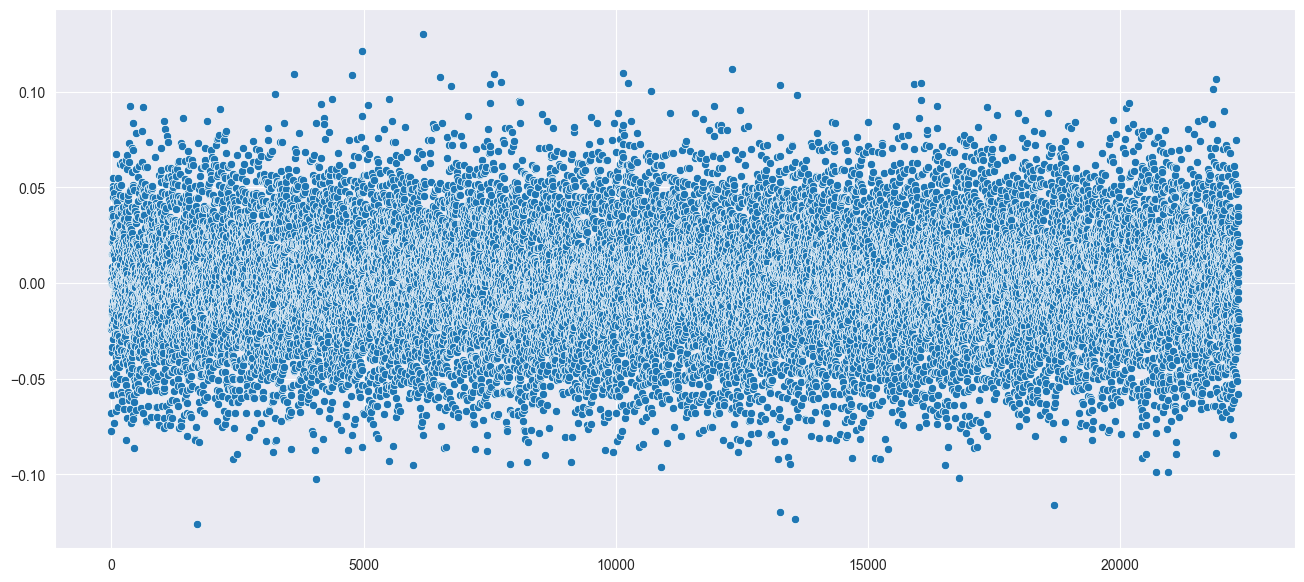

In [25]:
_ = plt.figure(figsize=(16,7))
ax = sns.scatterplot(data=funk_svd_score)

In [26]:
np.percentile(funk_svd_score, [0, 25, 50, 75, 100])


array([-0.12574932, -0.02071441,  0.00033869,  0.02080871,  0.1301741 ])

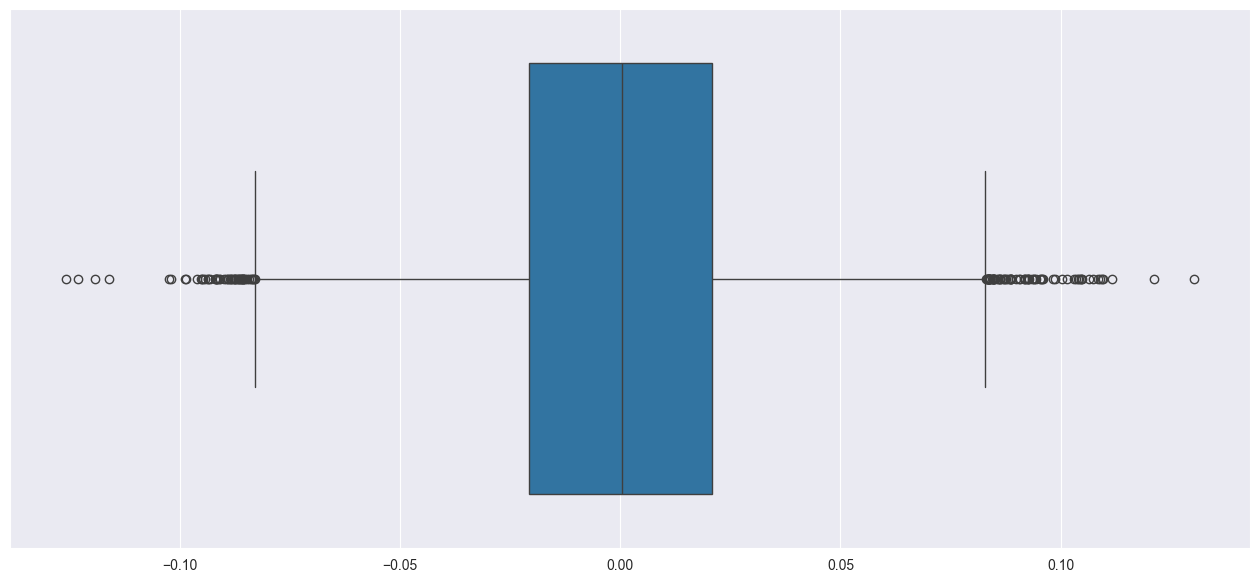

In [27]:
_ = plt.figure(figsize=(16,7))
ax = sns.boxplot(x=funk_svd_score)

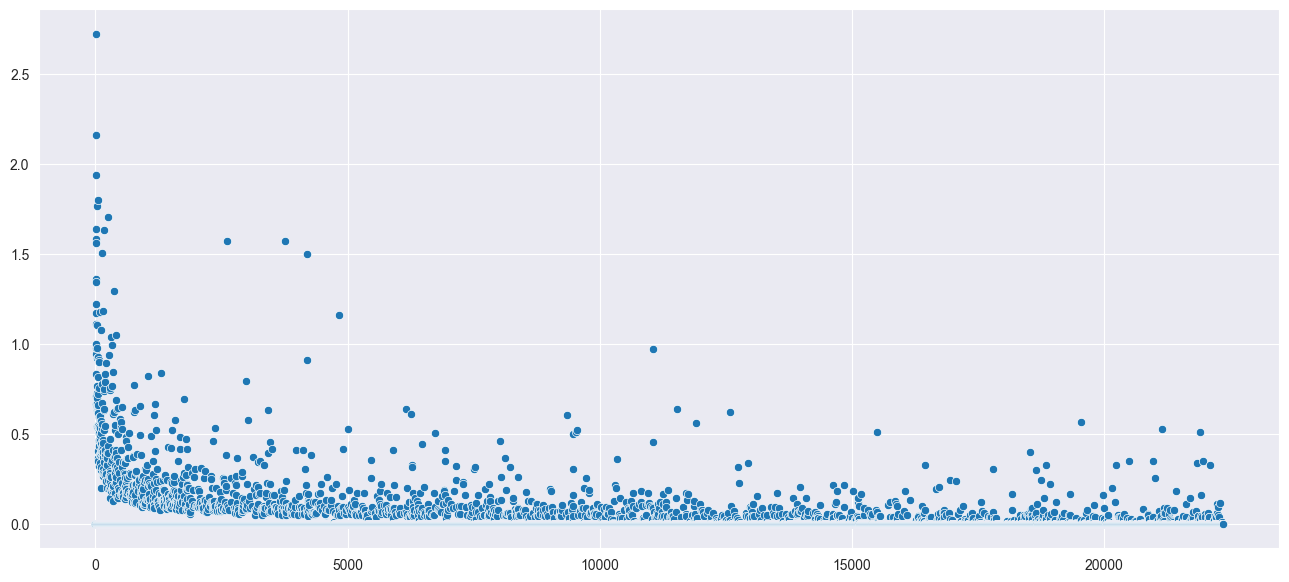

In [28]:
_ = plt.figure(figsize=(16,7))
ax = sns.scatterplot(data=slim_bpr_score)

In [29]:
np.percentile(slim_bpr_score, [0, 25, 50, 75, 100])


array([-1.01714766e-04,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        2.72424984e+00])

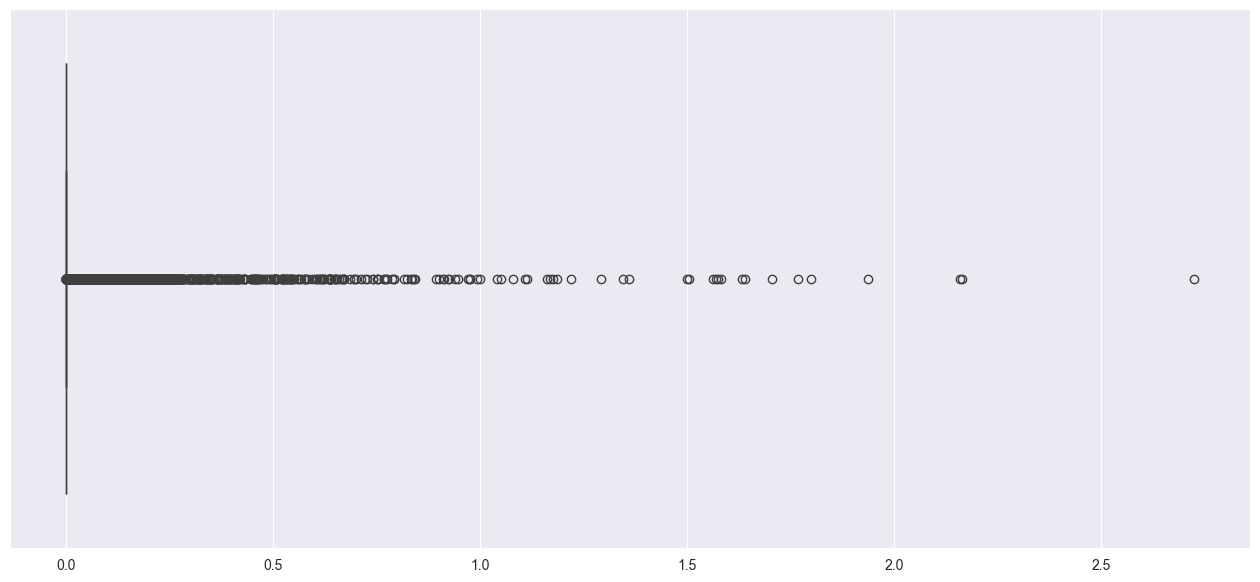

In [30]:
_ = plt.figure(figsize=(16,7))
ax = sns.boxplot(x=slim_bpr_score)

As you can see from the plots and the percentiles, the values held in each score array is totally different from one to another. 

As such, we need a way to _normalize_ these scores to be able to merge them into one.

[ 0.00153662 -0.06771982 -0.02397232 ...  0.02153803 -0.01875422
  0.0124    ] 0.13017409927247203 4.587615064975939 0.13017409927247203 3.711181077017088e-06


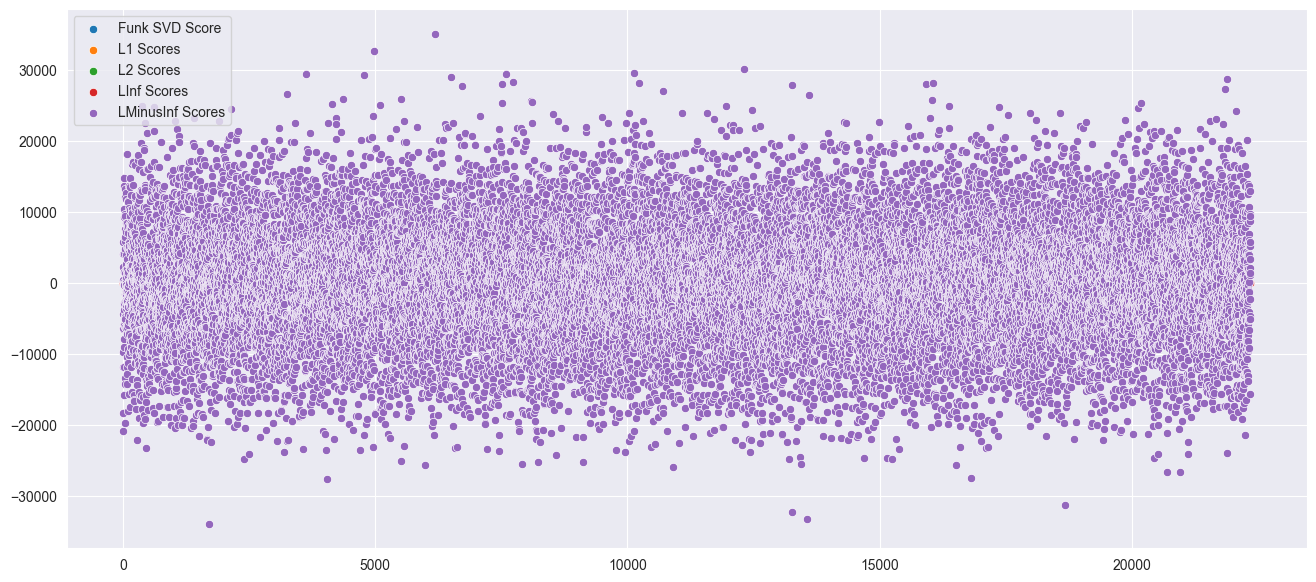

In [31]:
l1_funk_svd = LA.norm([funk_svd_score], 1)
l1_funk_svd_scores = funk_svd_score / l1_funk_svd

l2_funk_svd = LA.norm([funk_svd_score], 2)
l2_funk_svd_scores = funk_svd_score / l2_funk_svd

linf_funk_svd = LA.norm(funk_svd_score, np.inf)
linf_funk_svd_scores = funk_svd_score / linf_funk_svd

lminusinf_funk_svd = LA.norm(funk_svd_score, -np.inf)
lminusinf_funk_svd_scores = funk_svd_score / lminusinf_funk_svd

print(funk_svd_score, l1_funk_svd, l2_funk_svd, linf_funk_svd, lminusinf_funk_svd)

_ = plt.figure(figsize=(16,7))
ax = sns.scatterplot(data=funk_svd_score)
ax = sns.scatterplot(data=l1_funk_svd_scores) 
ax = sns.scatterplot(data=l2_funk_svd_scores) 
ax = sns.scatterplot(data=linf_funk_svd_scores) 
ax = sns.scatterplot(data=lminusinf_funk_svd_scores) 
ax.legend(["Funk SVD Score", "L1 Scores", "L2 Scores", "LInf Scores", "LMinusInf Scores"])

Similarly, we can do the same with SLIM BPR scores

/var/folders/45/5q6zskw54k5crwq2ngs9b_mh0000gn/T/ipykernel_25517/2192245264.py:11: RuntimeWarning: divide by zero encountered in divide
  lminusinf_slim_bpr_scores = slim_bpr_score / lminusinf_slim_bpr
/var/folders/45/5q6zskw54k5crwq2ngs9b_mh0000gn/T/ipykernel_25517/2192245264.py:11: RuntimeWarning: invalid value encountered in divide
  lminusinf_slim_bpr_scores = slim_bpr_score / lminusinf_slim_bpr


[0.0000000e+00 1.5831361e+00 1.5632391e+00 ... 5.4135326e-05 0.0000000e+00
 0.0000000e+00] 290.24576 12.441123 2.7242498 0.0


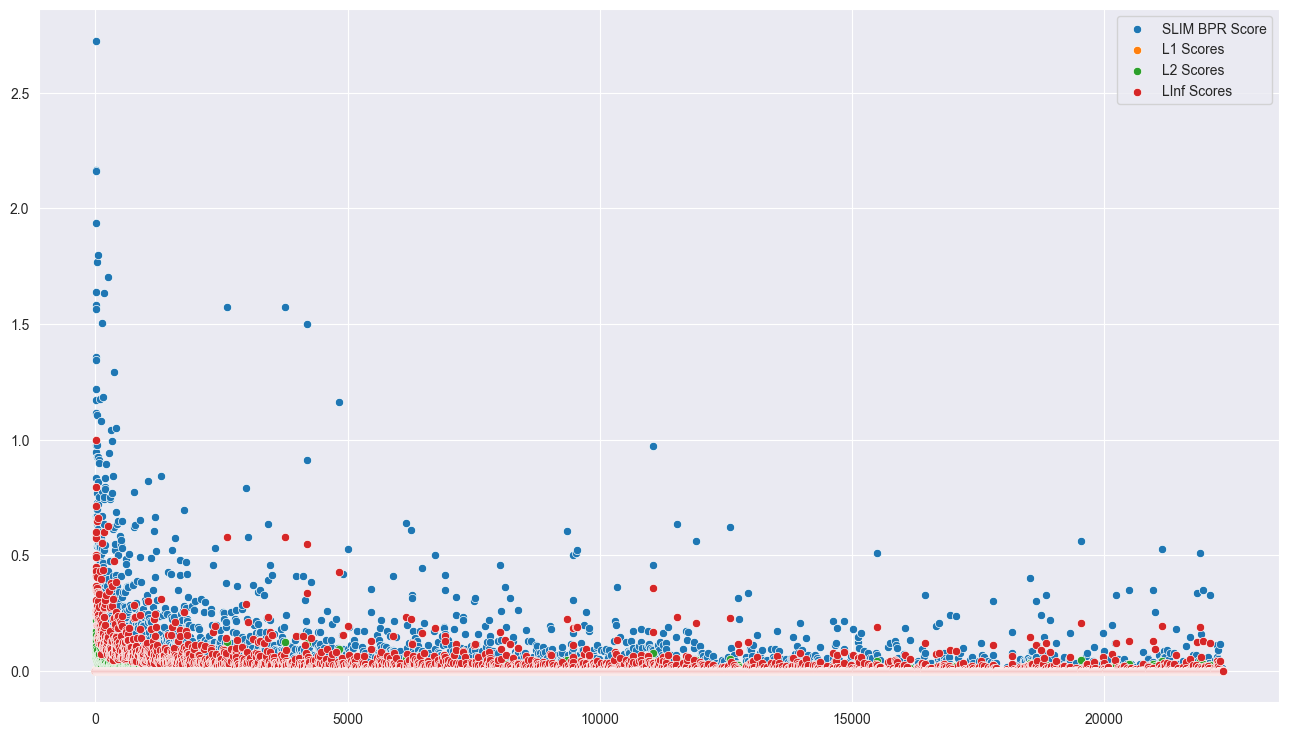

In [32]:
l1_slim_bpr = LA.norm(slim_bpr_score, 1)
l1_slim_bpr_scores = slim_bpr_score / l1_slim_bpr

l2_slim_bpr = LA.norm(slim_bpr_score, 2)
l2_slim_bpr_scores = slim_bpr_score / l2_slim_bpr

linf_slim_bpr = LA.norm(slim_bpr_score, np.inf)
linf_slim_bpr_scores = slim_bpr_score / linf_slim_bpr

lminusinf_slim_bpr = LA.norm(slim_bpr_score, -np.inf)
lminusinf_slim_bpr_scores = slim_bpr_score / lminusinf_slim_bpr

print(slim_bpr_score, l1_slim_bpr, l2_slim_bpr, linf_slim_bpr, lminusinf_slim_bpr)

_ = plt.figure(figsize=(16,9))
ax = sns.scatterplot(data=slim_bpr_score)
ax = sns.scatterplot(data=l1_slim_bpr_scores) 
ax = sns.scatterplot(data=l2_slim_bpr_scores) 
ax = sns.scatterplot(data=linf_slim_bpr_scores) 
ax = sns.scatterplot(data=lminusinf_slim_bpr_scores) 
ax.legend(["SLIM BPR Score", "L1 Scores", "L2 Scores", "LInf Scores", "LMinusInf Scores"])

Now that we have *normalized* the different item score vectors, we can merge the models.

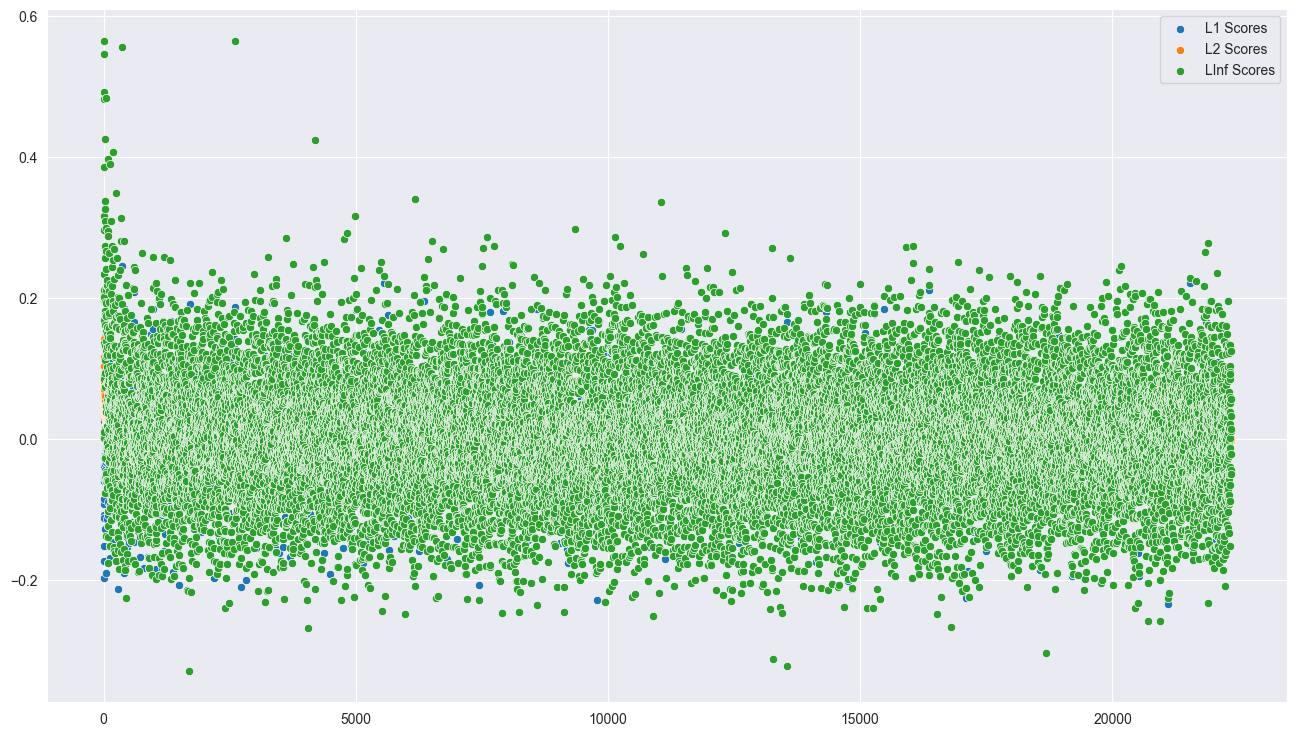

In [33]:
lambda_weights = 0.66

l1_new_scores = lambda_weights * l1_slim_bpr_scores + (1 - lambda_weights) * l1_funk_svd_scores
l2_new_scores = lambda_weights * l2_slim_bpr_scores + (1 - lambda_weights) * l2_funk_svd_scores
linf_new_scores = lambda_weights * linf_slim_bpr_scores + (1 - lambda_weights) * linf_funk_svd_scores
lminusinf_new_scores = lambda_weights * lminusinf_slim_bpr_scores + (1 - lambda_weights) * lminusinf_funk_svd_scores

_ = plt.figure(figsize=(16,9))
ax = sns.scatterplot(data=l1_new_scores)
ax = sns.scatterplot(data=l2_new_scores) 
ax = sns.scatterplot(data=linf_new_scores) 
ax = sns.scatterplot(data=lminusinf_new_scores) 
ax.legend(["L1 Scores", "L2 Scores", "LInf Scores", "LMinusInf Scores"])

Now, we have everything to create our hybrid.

In [34]:
class DifferentLossScoresHybridRecommender(BaseRecommender):
    """ ScoresHybridRecommender
    Hybrid of two prediction scores R = R1/norm*alpha + R2/norm*(1-alpha) where R1 and R2 come from
    algorithms trained on different loss functions.

    """

    RECOMMENDER_NAME = "DifferentLossScoresHybridRecommender"


    def __init__(self, URM_train, recommender_1, recommender_2):
        super(DifferentLossScoresHybridRecommender, self).__init__(URM_train)

        self.URM_train = sps.csr_matrix(URM_train)
        self.recommender_1 = recommender_1
        self.recommender_2 = recommender_2
        
        
        
    def fit(self, norm, alpha = 0.5):

        self.alpha = alpha
        self.norm = norm


    def _compute_item_score(self, user_id_array, items_to_compute):
        
        item_weights_1 = self.recommender_1._compute_item_score(user_id_array)
        item_weights_2 = self.recommender_2._compute_item_score(user_id_array)

        norm_item_weights_1 = LA.norm(item_weights_1, self.norm)
        norm_item_weights_2 = LA.norm(item_weights_2, self.norm)
        
        
        if norm_item_weights_1 == 0:
            raise ValueError("Norm {} of item weights for recommender 1 is zero. Avoiding division by zero".format(self.norm))
        
        if norm_item_weights_2 == 0:
            raise ValueError("Norm {} of item weights for recommender 2 is zero. Avoiding division by zero".format(self.norm))
        
        item_weights = item_weights_1 / norm_item_weights_1 * self.alpha + item_weights_2 / norm_item_weights_2 * (1-self.alpha)

        return item_weights



In [35]:
recommender_object = DifferentLossScoresHybridRecommender(URM_train, funk_svd_recommender, slim_bpr_recommender)

for norm in [1, 2, np.inf, -np.inf]:

    recommender_object.fit(norm, alpha = 0.66)

    result_df, _ = evaluator_validation.evaluateRecommender(recommender_object)
    print("Norm: {}, Result: {}".format(norm, result_df.loc[10]["MAP"]))

DifferentLossScoresHybridRecommender: URM Detected 802 ( 6.2%) users with no interactions.
DifferentLossScoresHybridRecommender: URM Detected 408 ( 1.8%) items with no interactions.
EvaluatorHoldout: Processed 9375 (100.0%) in 18.41 sec. Users per second: 509
Norm: 1, Result: 0.0015708867724867715
EvaluatorHoldout: Processed 9375 (100.0%) in 1.05 min. Users per second: 149
Norm: 2, Result: 0.010428842328042264
EvaluatorHoldout: Processed 9375 (100.0%) in 17.75 sec. Users per second: 528
Norm: inf, Result: 0.01270653121693113


ValueError: Norm -inf of item weights for recommender 2 is zero. Avoiding division by zero

## Important note:

You can build a hybrid with any number of techniques and models, be advised however that optimizing them is difficult.
* If you use already trained and optimized models and try to combine them you have a weight per each model and possibly a normalization. If you put together 10 models it will be difficult for the optimizer to find good hyperparameters due to a number of problems, for example the noise introduced by the lower performing algorithms;
* If you decide to try to optimize both the hybrid hyperparameters and each single model hyperparameters all at once, you end up with hundreds of hyperparameters to optimize. In theory you could be able to find a better result, in practice you will likely not.
* Some strategies can be used to minimize this, for example some smart initial points you provide to the optimizer... Maybe you start from all the hyperparameter configurations of the single models taken independently that you have already optimized, you use them as initialization points for the optimizer and then you try to *further* optimize them as part of the hybrid. (may be complicated, result is not guaranteed) 

A good solution is to proceed incrementally. For example:
* Start with the best model and set a weight and normalization, let's say 1.0 and l1;
* Add the second-best model and try to create a hybrid of the two optimizing only weight and normalization of the model you are trying to add;
* Once the optimization concludes, check if the hybrid is better than before or not. If it is better keep the new hybrid, if not remove the second-best model.
* Continue trying to add the third-best, fourth-best and so on...
* If you are lucky every now and then a new model can be added and the quality improves. (again, result not guaranteed)


Alternatively you can combine the model predictions with more complex strategies, for example with XGBoost. This is usually the go-to approach for hybrids that we use in the international challenges but goes beyond the scope of this course.

# Some tricks, user-wise hybrids

Models do not have the same accuracy for different user types. Let's divide the users according to their profile length and then compare the recommendation quality we get from a CF model.

Let's categorize user based on the number of interactions they have.

In [36]:
import numpy as np 
import scipy.sparse as sps

profile_length = np.ediff1d(sps.csr_matrix(URM_train).indptr)
profile_length, profile_length.shape

(array([ 0, 28, 22, ...,  4, 17, 47], dtype=int32), (13025,))

Let's select a few groups of 5% of the users with the least number of interactions.

In [47]:
block_size = int(len(profile_length)*0.05)
block_size

651

In [48]:
sorted_users = np.argsort(profile_length)
sorted_users

array([    0, 11798, 11803, ...,  5659,  9912, 12096])

In [49]:
for group_id in range(0, 20):
    start_pos = group_id * block_size
    end_pos = min((group_id+1) * block_size, len(profile_length))
    
    users_in_group = sorted_users[start_pos:end_pos]
    
    users_in_group_p_len = profile_length[users_in_group]
    
    print("Group {}, #users in group {}, average p.len {:.2f}, median {}, min {}, max {}".format(
        group_id, 
        users_in_group.shape[0],
        users_in_group_p_len.mean(),
        np.median(users_in_group_p_len),
        users_in_group_p_len.min(),
        users_in_group_p_len.max()))
    

Group 0, #users in group 651, average p.len 0.00, median 0.0, min 0, max 0
Group 1, #users in group 651, average p.len 0.77, median 1.0, min 0, max 1
Group 2, #users in group 651, average p.len 1.12, median 1.0, min 1, max 2
Group 3, #users in group 651, average p.len 2.00, median 2.0, min 2, max 2
Group 4, #users in group 651, average p.len 2.94, median 3.0, min 2, max 3
Group 5, #users in group 651, average p.len 4.03, median 4.0, min 3, max 5
Group 6, #users in group 651, average p.len 5.33, median 5.0, min 5, max 6
Group 7, #users in group 651, average p.len 6.59, median 7.0, min 6, max 7
Group 8, #users in group 651, average p.len 8.40, median 8.0, min 7, max 9
Group 9, #users in group 651, average p.len 10.44, median 10.0, min 9, max 12
Group 10, #users in group 651, average p.len 12.90, median 13.0, min 12, max 14
Group 11, #users in group 651, average p.len 15.59, median 16.0, min 14, max 17
Group 12, #users in group 651, average p.len 18.99, median 19.0, min 17, max 21
Group 1

Now let's calculate the evaluation metrics of each recommender when considering groups of users.

In [46]:
from Recommenders.NonPersonalizedRecommender import TopPop
from Recommenders.KNN.UserKNNCFRecommender import UserKNNCFRecommender
from Recommenders.KNN.ItemKNNCFRecommender import ItemKNNCFRecommender
from Recommenders.SLIM.SLIM_BPR_Python import SLIM_BPR_Python
from Recommenders.GraphBased.P3alphaRecommender import P3alphaRecommender
from Recommenders.GraphBased.RP3betaRecommender import RP3betaRecommender
from Recommenders.MatrixFactorization.PureSVDRecommender import PureSVDRecommender
from Recommenders.MatrixFactorization.NMFRecommender import NMFRecommender

MAP_recommender_per_group = {}

collaborative_recommender_class = {"TopPop": TopPop,
                                   "UserKNNCF": UserKNNCFRecommender,
                                   "ItemKNNCF": ItemKNNCFRecommender,
                                   "P3alpha": P3alphaRecommender,
                                   "RP3beta": RP3betaRecommender,
                                   "PureSVD": PureSVDRecommender,
                                   "NMF": NMFRecommender,
                                   "SLIMBPR": SLIM_BPR_Python,
                                   }

recommender_object_dict = {}

for label, recommender_class in collaborative_recommender_class.items():
    recommender_object = recommender_class(URM_train)
    recommender_object.fit()
    recommender_object_dict[label] = recommender_object

TopPopRecommender: URM Detected 802 ( 6.2%) users with no interactions.
TopPopRecommender: URM Detected 408 ( 1.8%) items with no interactions.
UserKNNCFRecommender: URM Detected 802 ( 6.2%) users with no interactions.
UserKNNCFRecommender: URM Detected 408 ( 1.8%) items with no interactions.
Unable to load Cython Compute_Similarity, reverting to Python
Similarity column 13025 (100.0%), 2031.63 column/sec. Elapsed time 6.41 sec
ItemKNNCFRecommender: URM Detected 802 ( 6.2%) users with no interactions.
ItemKNNCFRecommender: URM Detected 408 ( 1.8%) items with no interactions.
Unable to load Cython Compute_Similarity, reverting to Python
Similarity column 22348 (100.0%), 1838.52 column/sec. Elapsed time 12.16 sec
P3alphaRecommender: URM Detected 802 ( 6.2%) users with no interactions.
P3alphaRecommender: URM Detected 408 ( 1.8%) items with no interactions.
P3alphaRecommender: Similarity column 22348 (100.0%), 3017.48 column/sec. Elapsed time 7.41 sec
RP3betaRecommender: URM Detected 802 

In [52]:
cutoff = 10

for group_id in range(0, 20):
    
    start_pos = group_id*block_size
    end_pos = min((group_id+1)*block_size, len(profile_length))
    
    users_in_group = sorted_users[start_pos:end_pos]
    
    users_in_group_p_len = profile_length[users_in_group]
    
    print("Group {}, #users in group {}, average p.len {:.2f}, median {}, min {}, max {}".format(
        group_id, 
        users_in_group.shape[0],
        users_in_group_p_len.mean(),
        np.median(users_in_group_p_len),
        users_in_group_p_len.min(),
        users_in_group_p_len.max()))
    
    
    users_not_in_group_flag = np.isin(sorted_users, users_in_group, invert=True)
    users_not_in_group = sorted_users[users_not_in_group_flag]
    
    evaluator_test = EvaluatorHoldout(URM_test, cutoff_list=[cutoff], ignore_users=users_not_in_group)
    
    for label, recommender in recommender_object_dict.items():
        result_df, _ = evaluator_test.evaluateRecommender(recommender)
        if label in MAP_recommender_per_group:
            MAP_recommender_per_group[label].append(result_df.loc[cutoff]["MAP"])
        else:
            MAP_recommender_per_group[label] = [result_df.loc[cutoff]["MAP"]]
        

Group 0, #users in group 651, average p.len 0.00, median 0.0, min 0, max 0
EvaluatorHoldout: Ignoring 2541 (19.5%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 12374 Users
EvaluatorHoldout: Processed 237 (100.0%) in 0.55 sec. Users per second: 430
EvaluatorHoldout: Processed 237 (100.0%) in 0.71 sec. Users per second: 333
EvaluatorHoldout: Processed 237 (100.0%) in 0.73 sec. Users per second: 324
EvaluatorHoldout: Processed 237 (100.0%) in 0.74 sec. Users per second: 320
EvaluatorHoldout: Processed 237 (100.0%) in 0.64 sec. Users per second: 370
EvaluatorHoldout: Processed 237 (100.0%) in 0.51 sec. Users per second: 468
EvaluatorHoldout: Processed 237 (100.0%) in 0.48 sec. Users per second: 497
EvaluatorHoldout: Processed 237 (100.0%) in 0.51 sec. Users per second: 460
Group 1, #users in group 651, average p.len 0.77, median 1.0, min 0, max 1
EvaluatorHoldout: Ignoring 2541 (19.5%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 1237

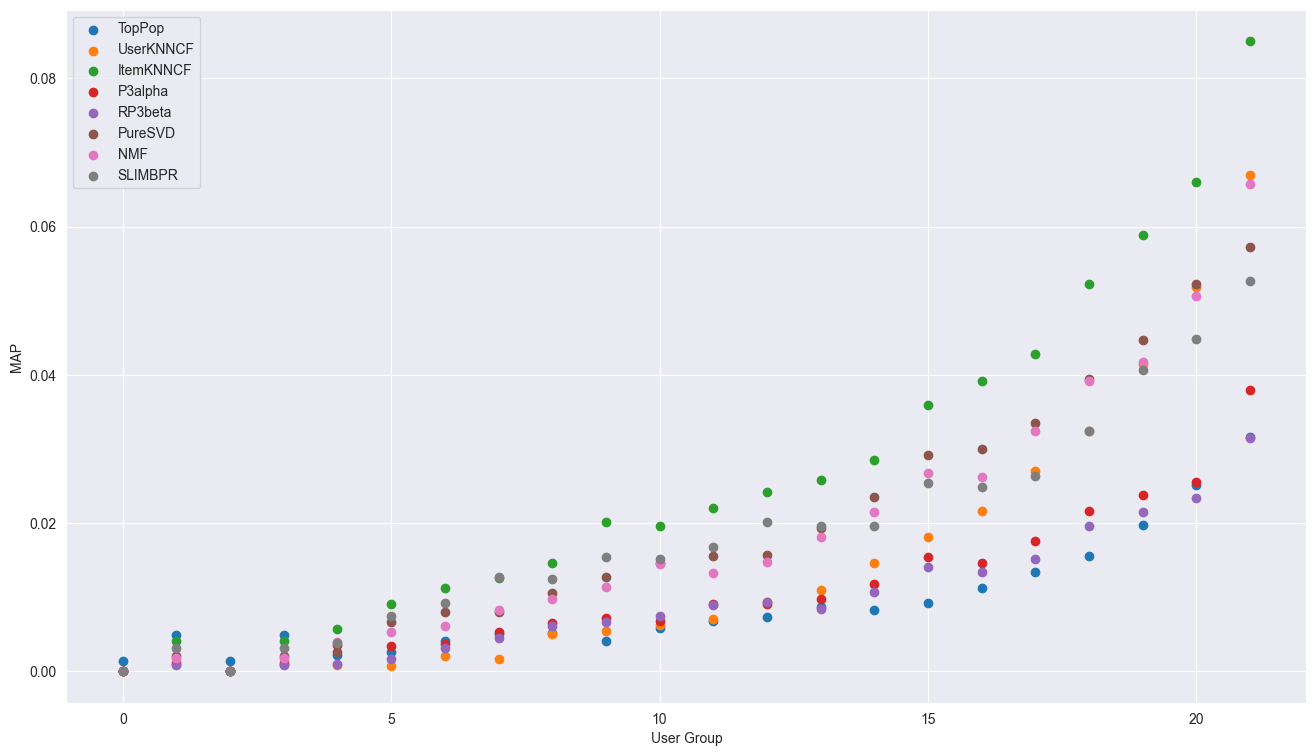

In [53]:
import matplotlib.pyplot as plt
%matplotlib inline  

_ = plt.figure(figsize=(16, 9))
for label, recommender in recommender_object_dict.items():
    results = MAP_recommender_per_group[label]
    plt.scatter(x=np.arange(0,len(results)), y=results, label=label)
plt.ylabel('MAP')
plt.xlabel('User Group')
plt.legend()
plt.show()

### The recommendation quality of the three algorithms changes depending on the user profile length

## Tip:
### If an algorithm works best on average, it does not imply it will work best for ALL user types